# Detect claims to fact check in political debates

In this project you will implement various classifiers using both neural and feature based technqiues to detect which sentences in political debates should be fact checked.
Dataset from ClaimBuster: https://zenodo.org/record/3609356 
Evaluate your classifiers using the same metrics as http://ranger.uta.edu/~cli/pubs/2017/claimbuster-kdd17-hassan.pdf (Table 2)

Classification report from sklearn provides everything

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import *

# Loading the data

In [2]:
df = pd.read_csv("../data_preprocessing/data_with_stop_words.csv")
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)
df.reset_index(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23533 entries, 0 to 23532
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       23533 non-null  int64         
 1   date        23533 non-null  datetime64[ns]
 2   Text        23533 non-null  object        
 3   Clean_text  23533 non-null  object        
 4   Verdict     23533 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 919.4+ KB


# Train-test split

In [3]:
mask = df["date"].dt.year < 2012

X_train = df.loc[mask, "Clean_text"].values
y_train = df.loc[mask, "Verdict"].values

X_test = df.loc[~mask, "Clean_text"].values
y_test = df.loc[~mask, "Verdict"].values

# Data Preprocessing

In [4]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## One hot encoding representation

The `Tokenizer` converts a text corpus into a list of integers. This class maps each word, and encodes the corpus. The map assigns an integer to every word and creates a dictionary, where the keys are the vocabulary terms themselves. Some parameters such as `num_words` set the maximum size of the vocabulary using the most comon words.

In [5]:
vocabulary_size = 5000
oov_token = "<OOV>"
tokenizer = Tokenizer(num_words = vocabulary_size)
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)

Encodding Test data

In [6]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)

In [7]:
word_index = tokenizer.word_index # same as vocabulary

## Padding sequences

In [8]:
max_length = 100
X_train_embedded=pad_sequences(X_train_encoded,padding='post',maxlen=max_length, truncating='post')
print(X_train_embedded)

[[  45   16   13 ...    0    0    0]
 [  44   93   22 ...    0    0    0]
 [   1  583 2982 ...    0    0    0]
 ...
 [   3    4   27 ...    0    0    0]
 [ 389 1378    5 ...    0    0    0]
 [   3  389   46 ...    0    0    0]]


### For training

In [9]:
X_train_embedded.shape

(18170, 100)

### For testing

In [10]:
X_test_embedded=pad_sequences(X_test_encoded,padding='post',maxlen=max_length)
print(X_test_embedded.shape)

(5363, 100)


### For the labels

In [11]:
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(y_train.reshape(-1, 1))
y_encoded = one_hot_encoder.transform(y_train.reshape(-1, 1))

y_encoded.shape

(18170, 3)

In [12]:
y_encoded_test = one_hot_encoder.transform(y_test.reshape(-1,1))
y_encoded_test.shape

(5363, 3)

# Creating the model

### Importing the pretrained weights for the embedding matrix

The pretrained weights used in this report are from the  <strong> Global Vectors for Word Representation </strong> `GloVe` model. Wich can be downloaded from https://nlp.stanford.edu/projects/glove/.

We chose the first option [glove.6B.zip](https://nlp.stanford.edu/data/glove.6B.zip), which contais Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 50d, 100d, 200d, & 300d vectors, 822 MB download). This option contains 4 `.txt` files. We use the `glove.6B.100d.txt` as our sequences were padded to have `max_len =100`

Once the zip file is downloaded, place the zip into the data folder and run the following code:

```import os
import zipfile
with zipfile.ZipFile('../data/glove.zip', 'r') as zip_ref:
    zip_ref.extractall('../data/glove')
```


In [13]:
embeddings_index = {}
f = open('../data/glove/glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400001 word vectors.


In [14]:
embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

### Defining plotting functions

- model history
- confusuion matrix

In [15]:
def plot_model_history(model_history):
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(model_history.history['loss'], label='train')
    plt.plot(model_history.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(model_history.history['accuracy'], label='train')
    plt.plot(model_history.history['val_accuracy'], label='test')
    plt.legend()
    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [16]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix'):
    """
    Plot the confusion matrix.
    Normalization is applied by setting `normalize=True`.

    Code soure: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    """
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Bidirectional LSTM 

In [17]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

callback =  EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=None,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

In [18]:
embedding_dim = 100
model_bi = Sequential()
model_bi.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_bi.add(Bidirectional(LSTM(100)))
model_bi.add(Dropout(0.5))
model_bi.add(Dense(97, activation = "relu"))
model_bi.add(Dense(3, activation='softmax'))
model_bi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1035300   
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 97)                19497     
                                                                 
 dense_1 (Dense)             (None, 3)                 294       
                                                                 
Total params: 1,215,891
Trainable params: 180,591
Non-trainable params: 1,035,300
________________________________________

In [19]:
model_bi.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 28s 55ms/step - loss: 0.6335 - accuracy: 0.7512 - val_loss: 0.6141 - val_accuracy: 0.7518
Epoch 2/10
455/455 [==============================] - 24s 52ms/step - loss: 0.5534 - accuracy: 0.7845 - val_loss: 0.5906 - val_accuracy: 0.7565
Epoch 3/10
455/455 [==============================] - 24s 52ms/step - loss: 0.5296 - accuracy: 0.7918 - val_loss: 0.5767 - val_accuracy: 0.7636
Epoch 4/10
455/455 [==============================] - 24s 53ms/step - loss: 0.5099 - accuracy: 0.7996 - val_loss: 0.5763 - val_accuracy: 0.7653
Epoch 5/10
455/455 [==============================] - 24s 53ms/step - loss: 0.4910 - accuracy: 0.8085 - val_loss: 0.5777 - val_accuracy: 0.7617
Epoch 6/10
455/455 [==============================] - 24s 53ms/step - loss: 0.4821 - accuracy: 0.8094 - val_loss: 0.5745 - val_accuracy: 0.7669
Epoch 7/10
455/455 [==============================] - 25s 54ms/step - loss: 0.4642 - accuracy: 0.8179 - val_loss: 0.5945 - val_accuracy:

In [20]:
predictions = model_bi.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.77      0.93      0.84      3314
         UFS       0.52      0.25      0.34       623
         CFS       0.70      0.53      0.60      1426

    accuracy                           0.74      5363
   macro avg       0.66      0.57      0.60      5363
weighted avg       0.72      0.74      0.72      5363



Confusion matrix, without normalization


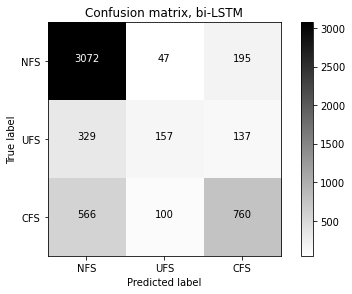

In [21]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix, bi-LSTM')

## Stacked Bi-LSTM

In [22]:
clear_session()

In [23]:
model_Sbi = Sequential()
model_Sbi.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_Sbi.add(Dropout(0.2))
model_Sbi.add(Bidirectional(LSTM(100, return_sequences=True)))
model_Sbi.add(Bidirectional(LSTM(100)))
model_Sbi.add(Dropout(0.2))
model_Sbi.add(Dense(97, activation = "relu"))
model_Sbi.add(Dense(3, activation='softmax'))
model_Sbi.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_Sbi.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1035300   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 100, 200)         160800    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              240800    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense (Dense)               (None, 97)                1

In [24]:
model_Sbi.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 63s 129ms/step - loss: 0.6267 - accuracy: 0.7468 - val_loss: 0.6112 - val_accuracy: 0.7578
Epoch 2/10
455/455 [==============================] - 57s 125ms/step - loss: 0.5574 - accuracy: 0.7790 - val_loss: 0.5862 - val_accuracy: 0.7600
Epoch 3/10
455/455 [==============================] - 58s 127ms/step - loss: 0.5303 - accuracy: 0.7914 - val_loss: 0.5954 - val_accuracy: 0.7614
Epoch 4/10
455/455 [==============================] - 59s 129ms/step - loss: 0.5171 - accuracy: 0.8006 - val_loss: 0.5670 - val_accuracy: 0.7722
Epoch 5/10
455/455 [==============================] - 57s 125ms/step - loss: 0.4985 - accuracy: 0.8065 - val_loss: 0.5582 - val_accuracy: 0.7705
Epoch 6/10
455/455 [==============================] - 57s 125ms/step - loss: 0.4802 - accuracy: 0.8120 - val_loss: 0.5697 - val_accuracy: 0.7603
Epoch 7/10
455/455 [==============================] - 57s 125ms/step - loss: 0.4675 - accuracy: 0.8185 - val_loss: 0.5536 - val_ac

In [25]:
predictions = model_Sbi.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.76      0.94      0.84      3314
         UFS       0.52      0.27      0.36       623
         CFS       0.72      0.47      0.57      1426

    accuracy                           0.74      5363
   macro avg       0.67      0.56      0.59      5363
weighted avg       0.72      0.74      0.71      5363



Confusion matrix, without normalization


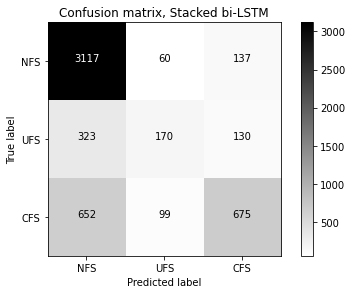

In [26]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix, Stacked bi-LSTM')

## Convolutional Neural Network

In [27]:
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
clear_session()


In [28]:
embedding_dim = 100

model = Sequential()
model.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model.add(Conv1D(128, 10, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1035300   
                                                                 
 conv1d (Conv1D)             (None, 91, 128)           128128    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 32)                4128      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,167,655
Trainable params: 132,355
Non-trainable params: 1,035,300
________________________________________

In [29]:
model.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 5s 11ms/step - loss: 0.6096 - accuracy: 0.7554 - val_loss: 0.6248 - val_accuracy: 0.7441
Epoch 2/10
455/455 [==============================] - 5s 11ms/step - loss: 0.4932 - accuracy: 0.8089 - val_loss: 0.6329 - val_accuracy: 0.7532
Epoch 3/10
455/455 [==============================] - 5s 11ms/step - loss: 0.4137 - accuracy: 0.8441 - val_loss: 0.6298 - val_accuracy: 0.7444
Epoch 4/10
455/455 [==============================] - 5s 11ms/step - loss: 0.3112 - accuracy: 0.8867 - val_loss: 0.6566 - val_accuracy: 0.7485
Epoch 5/10
455/455 [==============================] - 5s 11ms/step - loss: 0.2131 - accuracy: 0.9265 - val_loss: 0.8236 - val_accuracy: 0.7441
Epoch 6/10
455/455 [==============================] - 5s 11ms/step - loss: 0.1313 - accuracy: 0.9573 - val_loss: 1.0925 - val_accuracy: 0.7380
Epoch 7/10
455/455 [==============================] - 5s 11ms/step - loss: 0.0923 - accuracy: 0.9705 - val_loss: 0.9426 - val_accuracy: 0.7309

In [30]:
predictions = model.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))

              precision    recall  f1-score   support

         NFS       0.77      0.88      0.82      3314
         UFS       0.41      0.32      0.36       623
         CFS       0.66      0.50      0.57      1426

    accuracy                           0.72      5363
   macro avg       0.61      0.57      0.58      5363
weighted avg       0.70      0.72      0.70      5363



Confusion matrix, without normalization


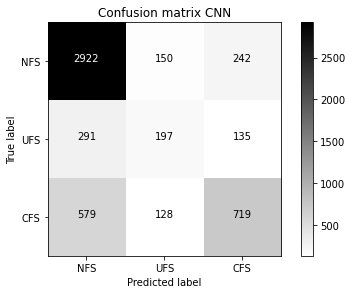

In [31]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix CNN')

## Convolutional Neural network + LSTM

In [32]:
model_conv = Sequential()
model_conv.add(Embedding(len(word_index) + 1, 
                         output_dim=max_length, 
                         input_length=max_length,
                         weights=[embedding_matrix],
                         trainable = False
                         ))
model_conv.add(Dropout(0.2))
model_conv.add(Conv1D(128, 10, activation='relu'))
model_conv.add(MaxPooling1D(pool_size=10))
model_conv.add(LSTM(100))
model_conv.add(Dense(32, activation = "relu"))
model_conv.add(Dense(3, activation='softmax'))
model_conv.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [33]:
model_conv.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          1035300   
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 91, 128)           128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 128)           0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               91600     
                                                                 
 dense_2 (Dense)             (None, 32)                3232      
                                                      

In [34]:
model_conv.fit(X_train_embedded,y_encoded, validation_split=0.2, epochs = 10
                #, callbacks=[callback]
                )

Epoch 1/10
455/455 [==============================] - 9s 17ms/step - loss: 0.6754 - accuracy: 0.7369 - val_loss: 0.7322 - val_accuracy: 0.7248
Epoch 2/10
455/455 [==============================] - 8s 17ms/step - loss: 0.5722 - accuracy: 0.7746 - val_loss: 0.6313 - val_accuracy: 0.7460
Epoch 3/10
455/455 [==============================] - 8s 17ms/step - loss: 0.5260 - accuracy: 0.7966 - val_loss: 0.6384 - val_accuracy: 0.7512
Epoch 4/10
455/455 [==============================] - 8s 17ms/step - loss: 0.4841 - accuracy: 0.8127 - val_loss: 0.6431 - val_accuracy: 0.7413
Epoch 5/10
455/455 [==============================] - 8s 17ms/step - loss: 0.4409 - accuracy: 0.8288 - val_loss: 0.6124 - val_accuracy: 0.7595
Epoch 6/10
455/455 [==============================] - 8s 17ms/step - loss: 0.3913 - accuracy: 0.8558 - val_loss: 0.7727 - val_accuracy: 0.7444
Epoch 7/10
455/455 [==============================] - 8s 17ms/step - loss: 0.3503 - accuracy: 0.8681 - val_loss: 0.6418 - val_accuracy: 0.7482

In [35]:
predictions = model_conv.predict(X_test_embedded)
preds = one_hot_encoder.inverse_transform(predictions).reshape(-1,)
print(classification_report(y_test, preds, target_names=["NFS", "UFS", "CFS"]))


              precision    recall  f1-score   support

         NFS       0.80      0.85      0.82      3314
         UFS       0.42      0.33      0.37       623
         CFS       0.62      0.57      0.59      1426

    accuracy                           0.72      5363
   macro avg       0.61      0.59      0.60      5363
weighted avg       0.70      0.72      0.71      5363



Confusion matrix, without normalization


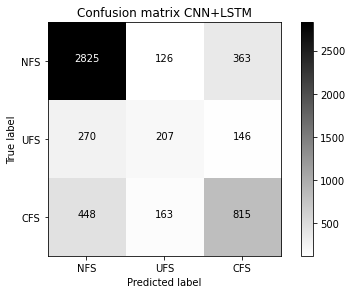

In [36]:
cm = confusion_matrix(y_test, preds)
plot_confusion_matrix(cm, classes=["NFS", "UFS", "CFS"], title='Confusion matrix CNN+LSTM')